In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ronimerdiansah","key":"348f3c0ae2b3fdaae4760582c857b6e3"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [ ]:
!kaggle datasets download -d olistbr/brazilian-ecommerce

 94% 40.0M/42.6M [00:02<00:00, 30.2MB/s]
100% 42.6M/42.6M [00:02<00:00, 19.5MB/s]


In [ ]:
!mkdir brazilian-ecommerce
!unzip brazilian-ecommerce.zip -d brazilian-ecommerce
!ls brazilian-ecommerce

Archive:  brazilian-ecommerce.zip
  inflating: brazilian-ecommerce/olist_customers_dataset.csv  
  inflating: brazilian-ecommerce/olist_geolocation_dataset.csv  
  inflating: brazilian-ecommerce/olist_order_items_dataset.csv  
  inflating: brazilian-ecommerce/olist_order_payments_dataset.csv  
  inflating: brazilian-ecommerce/olist_order_reviews_dataset.csv  
  inflating: brazilian-ecommerce/olist_orders_dataset.csv  
  inflating: brazilian-ecommerce/olist_products_dataset.csv  
  inflating: brazilian-ecommerce/olist_sellers_dataset.csv  
  inflating: brazilian-ecommerce/product_category_name_translation.csv  
olist_customers_dataset.csv	  olist_orders_dataset.csv
olist_geolocation_dataset.csv	  olist_products_dataset.csv
olist_order_items_dataset.csv	  olist_sellers_dataset.csv
olist_order_payments_dataset.csv  product_category_name_translation.csv
olist_order_reviews_dataset.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from functools import reduce
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report
import pickle
from pathlib import Path

import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
from math import ceil

## Membaca File CSV

In [ ]:
customers_df = pd.read_csv('brazilian-ecommerce/olist_customers_dataset.csv')
geolocation_df = pd.read_csv('brazilian-ecommerce/olist_geolocation_dataset.csv')
order_items_df = pd.read_csv('brazilian-ecommerce/olist_order_items_dataset.csv')
order_payments_df = pd.read_csv('brazilian-ecommerce/olist_order_payments_dataset.csv')
order_reviews_df = pd.read_csv('brazilian-ecommerce/olist_order_reviews_dataset.csv')
orders_df = pd.read_csv('brazilian-ecommerce/olist_orders_dataset.csv')
products_df = pd.read_csv('brazilian-ecommerce/olist_products_dataset.csv')
sellers_df = pd.read_csv('brazilian-ecommerce/olist_sellers_dataset.csv')
translation_df = pd.read_csv('brazilian-ecommerce/product_category_name_translation.csv')

## Melihat Info Semua Dataset

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
customers_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [ ]:
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [ ]:
geolocation_df.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [ ]:
geolocation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [ ]:
order_items_df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [ ]:
order_items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [ ]:
order_payments_df.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [ ]:
order_payments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [ ]:
order_reviews_df.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [ ]:
order_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [ ]:
orders_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [ ]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [ ]:
products_df.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [ ]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [ ]:
sellers_df.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [ ]:
sellers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


In [ ]:
translation_df.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [ ]:
translation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


## Data Cleansing

### Mengubah Nama Kolom

In [ ]:
# Data Customers
customers_df.rename(columns = {'customer_zip_code_prefix':'zip_code_prefix',
                                    'customer_city':'city',
                                    'customer_state':'state'}, inplace = True)

# Data Geolocation
geolocation_df.rename(columns = {'geolocation_zip_code_prefix':'zip_code_prefix',
                                      'geolocation_city':'city',
                                      'geolocation_state':'state'}, inplace = True)

# Data Sellers
sellers_df.rename(columns = {'seller_zip_code_prefix':'zip_code_prefix',
                                  'seller_city':'city',
                                  'seller_state':'state'}, inplace = True)

### Mengubah Tipe Data Kolom

In [ ]:
# Data Order Item
order_items_df['shipping_limit_date'] = order_items_df['shipping_limit_date'].apply(
    pd.to_datetime, errors='coerce')

# Data Order Reviews
order_reviews_df.iloc[:, 5:7] = order_reviews_df.iloc[:, 5:7].apply(pd.to_datetime, errors='coerce')

# Data Orders
orders_cols = orders_df.columns[3:]
orders_df[orders_cols] = orders_df[orders_cols].apply(pd.to_datetime, errors='coerce')

### Menggabungkan Dataset

In [ ]:
merge_dataset1 = [orders_df, order_items_df, order_payments_df, order_reviews_df]
dataset1 = reduce(lambda left,right: pd.merge(left,right,how='left',on='order_id'), merge_dataset1)

dataset2 = pd.merge(dataset1, sellers_df, how='right', on='seller_id')

dataset3 = pd.merge(dataset2, products_df, how='left', on='product_id')

dataset = pd.merge(dataset3, customers_df, how='left', on=['customer_id',
                                                           'zip_code_prefix',
                                                           'city','state'])

### Handling Missing Value dan Data Duplicate

In [ ]:
# Drop Kolom yang memilki banyak nilai null
cleaned_dataset = dataset.drop(['review_comment_title',
                                'review_comment_message',
                                'customer_unique_id'], axis=1)

# Drop baris yang memiliki nilai null
cleaned_dataset = cleaned_dataset.dropna()

# Drop order_id yang duplikasi
cleaned_dataset = cleaned_dataset.drop_duplicates(subset=['order_id'])

# Drop review_id yang duplikasi
cleaned_dataset = cleaned_dataset.drop_duplicates(subset=['review_id'])

In [ ]:
cleaned_dataset

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_creation_date,review_answer_timestamp,zip_code_prefix,city,state,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,6d953888a914b67350d5bc4d48f2acab,a973c4e3ad82777add3fa188f91dacea,delivered,2017-05-05 16:12:29,2017-05-05 16:25:11,2017-05-12 05:43:55,2017-06-02 16:57:44,2017-05-30,1.0,f4621f8ad6f54a2e3c408884068be46d,3442f8959a84dea7ee197c632cb2df15,2017-05-11 16:25:11,101.70,15.92,1.0,credit_card,2.0,117.62,b9b791819c5c1a5c6a4ffc7881f97fb5,1.0,2017-06-01,2017-06-01 12:57:10,13023,campinas,SP,esporte_lazer,27.0,485.0,2.0,600.0,35.0,15.0,28.0
1,bc8a5de6abf5b14f98a6135a7fb46731,1554ffe702931a062b4383b109accf63,delivered,2017-08-30 11:47:52,2017-08-30 12:50:19,2017-08-30 19:22:18,2017-09-01 16:51:26,2017-09-20,2.0,325a06bcce0da45b7f4ecf2797dd40e4,3442f8959a84dea7ee197c632cb2df15,2017-09-05 12:50:19,10.80,2.42,1.0,credit_card,4.0,158.80,cc77a6d63753c1d7b88b7c64630b97b9,3.0,2017-09-02,2017-09-03 17:31:14,13023,campinas,SP,esporte_lazer,44.0,1089.0,1.0,300.0,16.0,5.0,15.0
2,4a90af3e85dd563884e2afeab1091394,9d6837f9700a3441e7183bff3bc4eef0,delivered,2017-08-21 20:35:44,2017-08-21 20:50:19,2017-08-29 20:33:29,2017-08-30 16:07:13,2017-09-01,1.0,ffb64e34a37740dafb6c88f1abd1fa61,3442f8959a84dea7ee197c632cb2df15,2017-08-25 20:50:19,106.20,9.56,1.0,credit_card,2.0,115.76,88980a9c50a6909fa1fe35ddab8fa1e2,5.0,2017-08-31,2017-08-31 21:37:39,13023,campinas,SP,esporte_lazer,26.0,417.0,3.0,700.0,43.0,15.0,35.0
3,1887b26eba419ce20f6fe34a6f88e80a,23fe51c9d4d1b1cef50c57b3c0babf5e,delivered,2017-04-28 14:20:07,2017-04-28 14:35:15,2017-05-02 13:39:21,2017-05-09 14:27:05,2017-06-01,1.0,765c417cdc38443aaa558a0159a98591,d1b65fc7debc3361ea86b5f14c68d2e2,2017-05-08 14:35:15,209.90,21.55,1.0,credit_card,8.0,231.45,9de1a1b5a62567638d90dcaa1ef7c90f,5.0,2017-05-10,2017-05-11 10:34:49,13844,mogi guacu,SP,malas_acessorios,26.0,998.0,7.0,3500.0,40.0,55.0,25.0
4,83f24bbc4f76a2730ba9c9cfa32e6d07,d49bac4ac7d77b956f2b185ab700fbf1,delivered,2017-04-27 09:09:44,2017-04-27 09:25:08,2017-04-27 13:47:44,2017-05-04 13:20:07,2017-06-06,1.0,765c417cdc38443aaa558a0159a98591,d1b65fc7debc3361ea86b5f14c68d2e2,2017-05-05 09:25:08,209.90,21.55,1.0,credit_card,3.0,231.45,683598a96354d366237bdb8797a55c3d,5.0,2017-05-05,2017-05-08 11:08:59,13844,mogi guacu,SP,malas_acessorios,26.0,998.0,7.0,3500.0,40.0,55.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118293,9d9866633100cc4ffb5fc63ee78fb52f,a19aaf0a448df405ce973d0eb03a8784,delivered,2018-04-05 16:56:38,2018-04-05 17:09:46,2018-04-06 17:42:39,2018-04-11 10:27:31,2018-04-17,1.0,977ba64f692dbbeeb81d35ad7f953c5f,74871d19219c7d518d0090283e03c137,2018-04-11 17:09:46,47.00,7.39,1.0,credit_card,1.0,54.39,7a8c6bc0ba8421c51f3e69323f45a5cb,5.0,2018-04-12,2018-04-12 14:45:34,4650,sao paulo,SP,esporte_lazer,34.0,545.0,1.0,300.0,24.0,20.0,21.0
118294,3cde763f687d3708ba577295e22ca8ad,b36af41320f44362e289b3b9a18290f6,delivered,2018-05-01 20:33:57,2018-05-01 20:55:32,2018-05-02 08:53:00,2018-05-07 22:08:48,2018-05-21,1.0,70aaba5ccf6aac45a3a7917f3a79c7e4,74871d19219c7d518d0090283e03c137,2018-05-07 20:55:32,203.80,15.52,1.0,credit_card,1.0,219.32,5b28318c3f8dae1fac5e5db91950e074,5.0,2018-05-08,2018-05-11 11:20:19,4650,sao paulo,SP,cool_stuff,46.0,1348.0,2.0,1400.0,25.0,21.0,21.0
118295,e6c4a6f6dd627304bc8f832080958a32,96abe7b6c735a2b8b72765a7e1ecd3e2,delivered,2018-07-30 18:33:10,2018-07-30 19:40:14,2018-07-31 14:39:00,2018-08-01 19:04:34,2018-08-06,1.0,0a9dafcfb351b0dd0fafd06b8f842b55,74871d19219c7d518d0090283e03c13

In [ ]:
cleaned_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94061 entries, 0 to 118309
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       94061 non-null  object        
 1   customer_id                    94061 non-null  object        
 2   order_status                   94061 non-null  object        
 3   order_purchase_timestamp       94061 non-null  datetime64[ns]
 4   order_approved_at              94061 non-null  datetime64[ns]
 5   order_delivered_carrier_date   94061 non-null  datetime64[ns]
 6   order_delivered_customer_date  94061 non-null  datetime64[ns]
 7   order_estimated_delivery_date  94061 non-null  datetime64[ns]
 8   order_item_id                  94061 non-null  float64       
 9   product_id                     94061 non-null  object        
 10  seller_id                      94061 non-null  object        
 11  shipping_limit

In [ ]:
cleaned_dataset.isnull().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
payment_sequential               0
payment_type                     0
payment_installments             0
payment_value                    0
review_id                        0
review_score                     0
review_creation_date             0
review_answer_timestamp          0
zip_code_prefix                  0
city                             0
state                            0
product_category_name            0
product_name_lenght              0
product_description_lenght       0
product_photos_qty  

## Feature Engineering

### Menentukan Waktu Acuan (Time Benchmark)

In [ ]:
cleaned_dataset['order_purchase_timestamp'].agg(['min', 'max'])

min   2016-10-03 09:44:50
max   2018-08-29 15:00:37
Name: order_purchase_timestamp, dtype: datetime64[ns]

In [ ]:
cleaned_dataset['review_creation_date'].agg(['min', 'max'])

min   2016-10-15
max   2018-08-31
Name: review_creation_date, dtype: datetime64[ns]

Karena tanggal maksimal nya adalah 2018, maka disini saya menganggap prediksi ini dilakukan tahun 2019 bukan waktu sekarang, dengan menggunakan asumsi bahwa customer yang churn adalah yang tidak melakukan transaksi selama 1 tahun. Bila menggunakan waktu sekarang maka hasil kolom *is churn* adalah semuanya True.

In [ ]:
# Membuat acuan waktu tahun 2019
time_benchmark = datetime.datetime(2019, 1, 1)
print(time_benchmark)

2019-01-01 00:00:00


### Membuat Kolom Recency

Sebelum membuat kolom *is churn*, kita harus terlebih dahulu membuat kolom *recency* untuk mengetahui berapa hari customer tidak melakukan transaksi lagi sejak terakhir kali

In [ ]:
recency_df = cleaned_dataset.groupby('customer_id')['order_purchase_timestamp'].max().reset_index()
recency_df = recency_df.rename({'order_purchase_timestamp':'most_recent'},axis = 1)
recency_df['most_recent'] = pd.to_datetime(recency_df.most_recent).dt.tz_localize(None)
recency_df.head()

,customer_id,most_recent
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17


In [ ]:
recency_df['recency'] = (time_benchmark - recency_df['most_recent']).dt.days
recency_df.head()

,customer_id,most_recent,recency
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,412
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,533
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,671
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,502
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,273


In [ ]:
recency_df[recency_df['recency'] > 365].shape

(42281, 3)

In [ ]:
recency_df.shape

(94061, 3)

In [ ]:
df_temp1 = cleaned_dataset.copy()
df_temp1 = df_temp1.merge(recency_df, how='left', on = 'customer_id')
df_temp1

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_creation_date,review_answer_timestamp,zip_code_prefix,city,state,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,most_recent,recency
0,6d953888a914b67350d5bc4d48f2acab,a973c4e3ad82777add3fa188f91dacea,delivered,2017-05-05 16:12:29,2017-05-05 16:25:11,2017-05-12 05:43:55,2017-06-02 16:57:44,2017-05-30,1.0,f4621f8ad6f54a2e3c408884068be46d,3442f8959a84dea7ee197c632cb2df15,2017-05-11 16:25:11,101.70,15.92,1.0,credit_card,2.0,117.62,b9b791819c5c1a5c6a4ffc7881f97fb5,1.0,2017-06-01,2017-06-01 12:57:10,13023,campinas,SP,esporte_lazer,27.0,485.0,2.0,600.0,35.0,15.0,28.0,2017-05-05 16:12:29,605
1,bc8a5de6abf5b14f98a6135a7fb46731,1554ffe702931a062b4383b109accf63,delivered,2017-08-30 11:47:52,2017-08-30 12:50:19,2017-08-30 19:22:18,2017-09-01 16:51:26,2017-09-20,2.0,325a06bcce0da45b7f4ecf2797dd40e4,3442f8959a84dea7ee197c632cb2df15,2017-09-05 12:50:19,10.80,2.42,1.0,credit_card,4.0,158.80,cc77a6d63753c1d7b88b7c64630b97b9,3.0,2017-09-02,2017-09-03 17:31:14,13023,campinas,SP,esporte_lazer,44.0,1089.0,1.0,300.0,16.0,5.0,15.0,2017-08-30 11:47:52,488
2,4a90af3e85dd563884e2afeab1091394,9d6837f9700a3441e7183bff3bc4eef0,delivered,2017-08-21 20:35:44,2017-08-21 20:50:19,2017-08-29 20:33:29,2017-08-30 16:07:13,2017-09-01,1.0,ffb64e34a37740dafb6c88f1abd1fa61,3442f8959a84dea7ee197c632cb2df15,2017-08-25 20:50:19,106.20,9.56,1.0,credit_card,2.0,115.76,88980a9c50a6909fa1fe35ddab8fa1e2,5.0,2017-08-31,2017-08-31 21:37:39,13023,campinas,SP,esporte_lazer,26.0,417.0,3.0,700.0,43.0,15.0,35.0,2017-08-21 20:35:44,497
3,1887b26eba419ce20f6fe34a6f88e80a,23fe51c9d4d1b1cef50c57b3c0babf5e,delivered,2017-04-28 14:20:07,2017-04-28 14:35:15,2017-05-02 13:39:21,2017-05-09 14:27:05,2017-06-01,1.0,765c417cdc38443aaa558a0159a98591,d1b65fc7debc3361ea86b5f14c68d2e2,2017-05-08 14:35:15,209.90,21.55,1.0,credit_card,8.0,231.45,9de1a1b5a62567638d90dcaa1ef7c90f,5.0,2017-05-10,2017-05-11 10:34:49,13844,mogi guacu,SP,malas_acessorios,26.0,998.0,7.0,3500.0,40.0,55.0,25.0,2017-04-28 14:20:07,612
4,83f24bbc4f76a2730ba9c9cfa32e6d07,d49bac4ac7d77b956f2b185ab700fbf1,delivered,2017-04-27 09:09:44,2017-04-27 09:25:08,2017-04-27 13:47:44,2017-05-04 13:20:07,2017-06-06,1.0,765c417cdc38443aaa558a0159a98591,d1b65fc7debc3361ea86b5f14c68d2e2,2017-05-05 09:25:08,209.90,21.55,1.0,credit_card,3.0,231.45,683598a96354d366237bdb8797a55c3d,5.0,2017-05-05,2017-05-08 11:08:59,13844,mogi guacu,SP,malas_acessorios,26.0,998.0,7.0,3500.0,40.0,55.0,25.0,2017-04-27 09:09:44,613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94056,9d9866633100cc4ffb5fc63ee78fb52f,a19aaf0a448df405ce973d0eb03a8784,delivered,2018-04-05 16:56:38,2018-04-05 17:09:46,2018-04-06 17:42:39,2018-04-11 10:27:31,2018-04-17,1.0,977ba64f692dbbeeb81d35ad7f953c5f,74871d19219c7d518d0090283e03c137,2018-04-11 17:09:46,47.00,7.39,1.0,credit_card,1.0,54.39,7a8c6bc0ba8421c51f3e69323f45a5cb,5.0,2018-04-12,2018-04-12 14:45:34,4650,sao paulo,SP,esporte_lazer,34.0,545.0,1.0,300.0,24.0,20.0,21.0,2018-04-05 16:56:38,270
94057,3cde763f687d3708ba577295e22ca8ad,b36af41320f44362e289b3b9a18290f6,delivered,2018-05-01 20:33:57,2018-05-01 20:55:32,2018-05-02 08:53:00,2018-05-07 22:08:48,2018-05-21,1.0,70aaba5ccf6aac45a3a7917f3a79c7e4,74871d19219c7d518d0090283e03c137,2018-05-07 20:55:32,203.80,15.52,1.0,credit_card,1.0,219.32,5b28318c3f8dae1fac5e5db91950e074,5.0,2018-05-08,2018-05-11 11:20:19,4650,sao paulo,SP,cool_stuff,46.0,1348.0,2.0,1400.0,25.0,21.0,21.0,2018-05-01 20:33:57,244
94058,e6c4a6f6dd627304bc8f832080958a32,96abe7b6c

In [ ]:
df_temp1.shape

(94061, 35)

### Membuat Kolom Churn

Setelah membuat kolom *recency*, selanjutnya kita membuat kolom *is churn* dengan asumsi bahwa customer yang tidak transaksi lagi selama 365 bernilai True.

In [ ]:
df_temp1['is_churn'] = df_temp1['recency'].apply(lambda x: True if x >= 365 else False)
df_temp1['is_churn'].value_counts()

False    51714
True     42347
Name: is_churn, dtype: int64

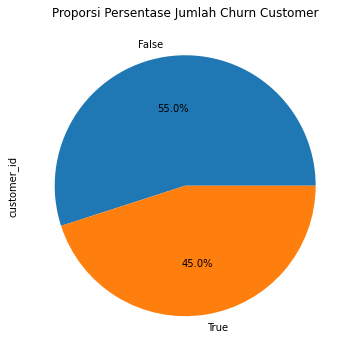

In [ ]:
churn = df_temp1.groupby(['is_churn'])['customer_id'].count()

plt.figure(figsize=(10,6))
plt.title('Proporsi Persentase Jumlah Churn Customer')

churn.plot.pie(autopct='%1.1f%%')
plt.show()

### Membuat Kolom Frequency

In [ ]:
customer_repurchase = df_temp1[['order_id','customer_id']].groupby('customer_id').count()
customer_repurchase.rename(columns={'order_id':'frequency'}, inplace=True)
customer_repurchase.value_counts()

frequency
1            94061
dtype: int64

In [ ]:
df_temp2 = df_temp1.merge(customer_repurchase, how = 'left', on = 'customer_id')
df_temp2.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_creation_date,review_answer_timestamp,zip_code_prefix,city,state,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,most_recent,recency,is_churn,frequency
0,6d953888a914b67350d5bc4d48f2acab,a973c4e3ad82777add3fa188f91dacea,delivered,2017-05-05 16:12:29,2017-05-05 16:25:11,2017-05-12 05:43:55,2017-06-02 16:57:44,2017-05-30,1.0,f4621f8ad6f54a2e3c408884068be46d,3442f8959a84dea7ee197c632cb2df15,2017-05-11 16:25:11,101.7,15.92,1.0,credit_card,2.0,117.62,b9b791819c5c1a5c6a4ffc7881f97fb5,1.0,2017-06-01,2017-06-01 12:57:10,13023,campinas,SP,esporte_lazer,27.0,485.0,2.0,600.0,35.0,15.0,28.0,2017-05-05 16:12:29,605,True,1
1,bc8a5de6abf5b14f98a6135a7fb46731,1554ffe702931a062b4383b109accf63,delivered,2017-08-30 11:47:52,2017-08-30 12:50:19,2017-08-30 19:22:18,2017-09-01 16:51:26,2017-09-20,2.0,325a06bcce0da45b7f4ecf2797dd40e4,3442f8959a84dea7ee197c632cb2df15,2017-09-05 12:50:19,10.8,2.42,1.0,credit_card,4.0,158.80,cc77a6d63753c1d7b88b7c64630b97b9,3.0,2017-09-02,2017-09-03 17:31:14,13023,campinas,SP,esporte_lazer,44.0,1089.0,1.0,300.0,16.0,5.0,15.0,2017-08-30 11:47:52,488,True,1
2,4a90af3e85dd563884e2afeab1091394,9d6837f9700a3441e7183bff3bc4eef0,delivered,2017-08-21 20:35:44,2017-08-21 20:50:19,2017-08-29 20:33:29,2017-08-30 16:07:13,2017-09-01,1.0,ffb64e34a37740dafb6c88f1abd1fa61,3442f8959a84dea7ee197c632cb2df15,2017-08-25 20:50:19,106.2,9.56,1.0,credit_card,2.0,115.76,88980a9c50a6909fa1fe35ddab8fa1e2,5.0,2017-08-31,2017-08-31 21:37:39,13023,campinas,SP,esporte_lazer,26.0,417.0,3.0,700.0,43.0,15.0,35.0,2017-08-21 20:35:44,497,True,1
3,1887b26eba419ce20f6fe34a6f88e80a,23fe51c9d4d1b1cef50c57b3c0babf5e,delivered,2017-04-28 14:20:07,2017-04-28 14:35:15,2017-05-02 13:39:21,2017-05-09 14:27:05,2017-06-01,1.0,765c417cdc38443aaa558a0159a98591,d1b65fc7debc3361ea86b5f14c68d2e2,2017-05-08 14:35:15,209.9,21.55,1.0,credit_card,8.0,231.45,9de1a1b5a62567638d90dcaa1ef7c90f,5.0,2017-05-10,2017-05-11 10:34:49,13844,mogi guacu,SP,malas_acessorios,26.0,998.0,7.0,3500.0,40.0,55.0,25.0,2017-04-28 14:20:07,612,True,1
4,83f24bbc4f76a2730ba9c9cfa32e6d07,d49bac4ac7d77b956f2b185ab700fbf1,delivered,2017-04-27 09:09:44,2017-04-27 09:25:08,2017-04-27 13:47:44,2017-05-04 13:20:07,2017-06-06,1.0,765c417cdc38443aaa558a0159a98591,d1b65fc7debc3361ea86b5f14c68d2e2,2017-05-05 09:25:08,209.9,21.55,1.0,credit_card,3.0,231.45,683598a96354d366237bdb8797a55c3d,5.0,2017-05-05,2017-05-08 11:08:59,13844,mogi guacu,SP,malas_acessorios,26.0,998.0,7.0,3500.0,40.0,55.0,25.0,2017-04-27 09:09:44,613,True,1


In [ ]:
df_temp2.shape

(94061, 37)

### Membuat Kolom Monetary

In [ ]:
total_purchase = df_temp2.groupby('customer_id')['payment_value'].sum().reset_index()
total_purchase = total_purchase.rename({'payment_value':'monetary'},axis = 1)
total_purchase.value_counts()

customer_id                       monetary
00012a2ce6f8dcda20d059ce98491703  114.74      1
aa6d96d0e25354fab970635297f96f7c  670.92      1
aa6c9d83b00de08bd2a32f934d7f275f  63.98       1
aa6c06fc582aea2912edc17eea2be533  38.27       1
aa6bbe83912aa4d9762752cf237ac30e  41.36       1
                                             ..
557ca53d56e4cd7f3ac2ba132c7540f1  39.85       1
557a197892a569cc513f0f016a7932d9  256.87      1
55797a8a69854e4fc1e636937f0c05eb  97.90       1
5579271655438f2905a24845dccbcd16  77.29       1
ffffa3172527f765de70084a7e53aae8  45.50       1
Length: 94061, dtype: int64

In [ ]:
df_temp3 = df_temp2.merge(total_purchase, how='left', on = 'customer_id')
df_temp3.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_creation_date,review_answer_timestamp,zip_code_prefix,city,state,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,most_recent,recency,is_churn,frequency,monetary
0,6d953888a914b67350d5bc4d48f2acab,a973c4e3ad82777add3fa188f91dacea,delivered,2017-05-05 16:12:29,2017-05-05 16:25:11,2017-05-12 05:43:55,2017-06-02 16:57:44,2017-05-30,1.0,f4621f8ad6f54a2e3c408884068be46d,3442f8959a84dea7ee197c632cb2df15,2017-05-11 16:25:11,101.7,15.92,1.0,credit_card,2.0,117.62,b9b791819c5c1a5c6a4ffc7881f97fb5,1.0,2017-06-01,2017-06-01 12:57:10,13023,campinas,SP,esporte_lazer,27.0,485.0,2.0,600.0,35.0,15.0,28.0,2017-05-05 16:12:29,605,True,1,117.62
1,bc8a5de6abf5b14f98a6135a7fb46731,1554ffe702931a062b4383b109accf63,delivered,2017-08-30 11:47:52,2017-08-30 12:50:19,2017-08-30 19:22:18,2017-09-01 16:51:26,2017-09-20,2.0,325a06bcce0da45b7f4ecf2797dd40e4,3442f8959a84dea7ee197c632cb2df15,2017-09-05 12:50:19,10.8,2.42,1.0,credit_card,4.0,158.80,cc77a6d63753c1d7b88b7c64630b97b9,3.0,2017-09-02,2017-09-03 17:31:14,13023,campinas,SP,esporte_lazer,44.0,1089.0,1.0,300.0,16.0,5.0,15.0,2017-08-30 11:47:52,488,True,1,158.80
2,4a90af3e85dd563884e2afeab1091394,9d6837f9700a3441e7183bff3bc4eef0,delivered,2017-08-21 20:35:44,2017-08-21 20:50:19,2017-08-29 20:33:29,2017-08-30 16:07:13,2017-09-01,1.0,ffb64e34a37740dafb6c88f1abd1fa61,3442f8959a84dea7ee197c632cb2df15,2017-08-25 20:50:19,106.2,9.56,1.0,credit_card,2.0,115.76,88980a9c50a6909fa1fe35ddab8fa1e2,5.0,2017-08-31,2017-08-31 21:37:39,13023,campinas,SP,esporte_lazer,26.0,417.0,3.0,700.0,43.0,15.0,35.0,2017-08-21 20:35:44,497,True,1,115.76
3,1887b26eba419ce20f6fe34a6f88e80a,23fe51c9d4d1b1cef50c57b3c0babf5e,delivered,2017-04-28 14:20:07,2017-04-28 14:35:15,2017-05-02 13:39:21,2017-05-09 14:27:05,2017-06-01,1.0,765c417cdc38443aaa558a0159a98591,d1b65fc7debc3361ea86b5f14c68d2e2,2017-05-08 14:35:15,209.9,21.55,1.0,credit_card,8.0,231.45,9de1a1b5a62567638d90dcaa1ef7c90f,5.0,2017-05-10,2017-05-11 10:34:49,13844,mogi guacu,SP,malas_acessorios,26.0,998.0,7.0,3500.0,40.0,55.0,25.0,2017-04-28 14:20:07,612,True,1,231.45
4,83f24bbc4f76a2730ba9c9cfa32e6d07,d49bac4ac7d77b956f2b185ab700fbf1,delivered,2017-04-27 09:09:44,2017-04-27 09:25:08,2017-04-27 13:47:44,2017-05-04 13:20:07,2017-06-06,1.0,765c417cdc38443aaa558a0159a98591,d1b65fc7debc3361ea86b5f14c68d2e2,2017-05-05 09:25:08,209.9,21.55,1.0,credit_card,3.0,231.45,683598a96354d366237bdb8797a55c3d,5.0,2017-05-05,2017-05-08 11:08:59,13844,mogi guacu,SP,malas_acessorios,26.0,998.0,7.0,3500.0,40.0,55.0,25.0,2017-04-27 09:09:44,613,True,1,231.45


In [ ]:
df_temp3.shape

(94061, 38)

In [ ]:
df_temp3.product_category_name.value_counts()

cama_mesa_banho                  8982
beleza_saude                     8529
esporte_lazer                    7401
informatica_acessorios           6426
moveis_decoracao                 6116
                                 ... 
la_cuisine                         12
cds_dvds_musicais                  12
pc_gamer                            7
fashion_roupa_infanto_juvenil       7
seguros_e_servicos                  2
Name: product_category_name, Length: 73, dtype: int64

## Exploratory Data Analysis (EDA)

In [ ]:
df_temp3 = pd.merge(df_temp3, translation_df, how='inner', on='product_category_name')

df_temp3['product_category_name_english'].value_counts()

bed_bath_table               8982
health_beauty                8529
sports_leisure               7401
computers_accessories        6426
furniture_decor              6116
                             ... 
home_comfort_2                 21
la_cuisine                     12
cds_dvds_musicals              12
fashion_childrens_clothes       7
security_and_services           2
Name: product_category_name_english, Length: 71, dtype: int64

### Churn Berdasarkan Tipe Pembayaran

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


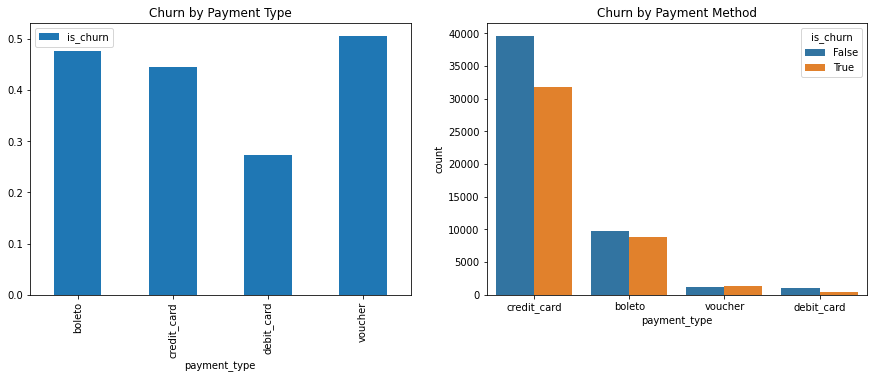

In [ ]:
f,ax=plt.subplots(1,2,figsize=(15,5))
df_temp3[['payment_type','is_churn']].groupby(['payment_type']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Churn by Payment Type')

sns.countplot('payment_type',hue='is_churn',data=df_temp3,ax=ax[1])
ax[1].set_title('Churn by Payment Method')
plt.show()

### Churn Berdasarkan Skor Review

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


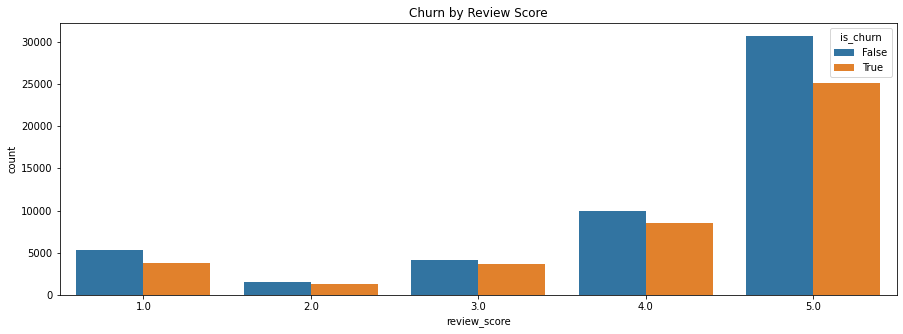

In [ ]:
f,ax=plt.subplots(figsize=(15,5))

sns.countplot('review_score',hue='is_churn',data=df_temp3,ax=ax)
ax.set_title('Churn by Review Score')
plt.show()

### Churn Berdasarkan Negara Bagian

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


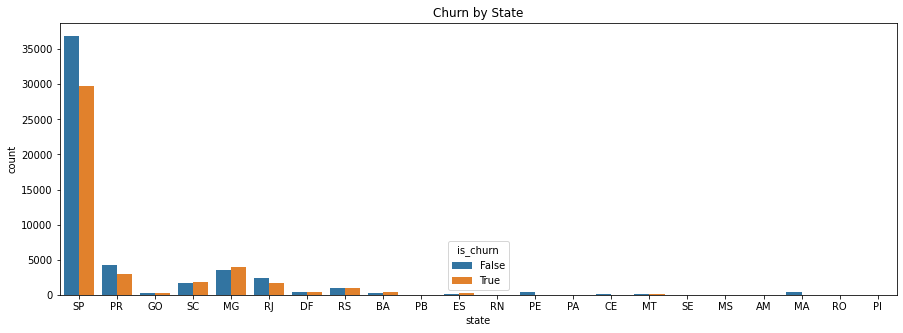

In [ ]:
f,ax=plt.subplots(figsize=(15,5))

sns.countplot('state',hue='is_churn',data=df_temp3,ax=ax)
ax.set_title('Churn by State')
plt.show()

### Churn Berdasarkan Kategori Nama Produk

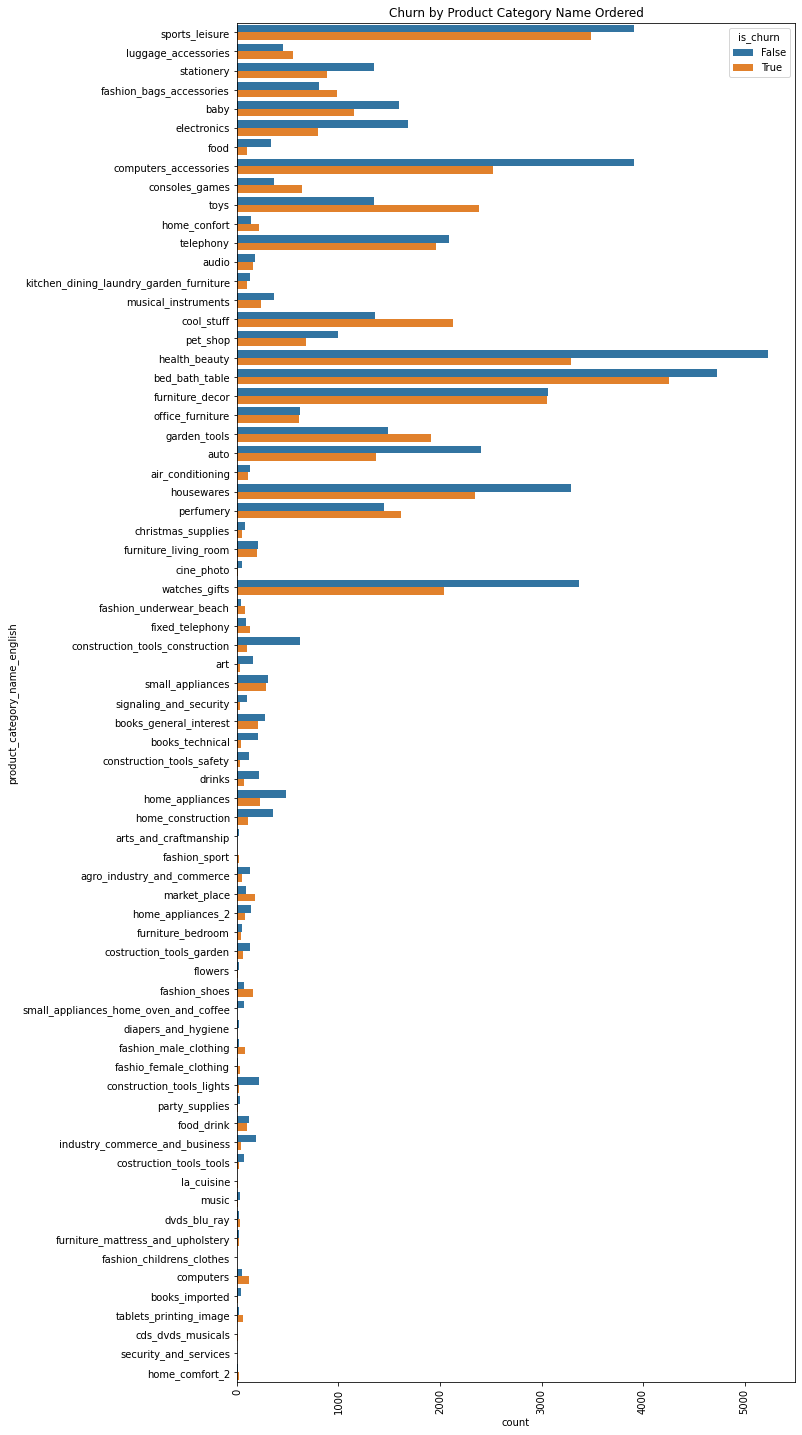

In [ ]:
f,ax=plt.subplots(figsize=(10,25))

sns.countplot(y='product_category_name_english', hue='is_churn',data=df_temp3,ax=ax)
ax.set_title('Churn by Product Category Name Ordered')
plt.xticks(rotation=90)
plt.show()

### Rata - Rata Monetary per Bulam

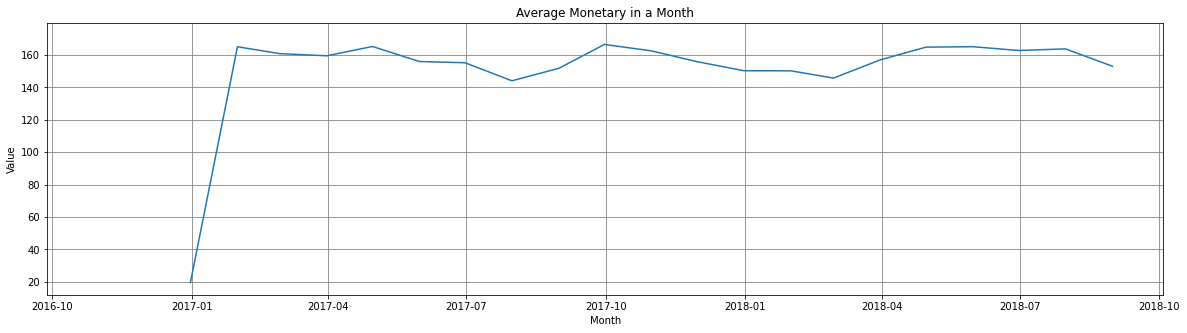

In [ ]:
avg_monetary = df_temp3.set_index('most_recent')

data_by_month = avg_monetary.resample('M').mean()

time = data_by_month.index.values
test = data_by_month['monetary'].values

plt.figure(figsize=(20,5))
plt.plot(time, test)
plt.title('Average Monetary in a Month')
plt.ylabel('Value')
plt.xlabel('Month')
plt.grid(color='grey')

### Encoding Data

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [ ]:
encoded_df = MultiColumnLabelEncoder(columns = ['order_status', 
                                   'payment_type',
                                   'order_item_id',
                                   'city',
                                   'state', 
                                   'product_category_name'
                                  ]).fit_transform(df_temp3)

In [ ]:
encoded_df.shape

(94041, 39)

In [ ]:
for col in encoded_df:
    print(f"\033[1m{col} \n{20 * '-'}\033[0m")
    print(encoded_df[col].value_counts(), '\n')

order_id 
--------------------
6d953888a914b67350d5bc4d48f2acab    1
5b686ee96f05cb6987dda1919ebf2bdf    1
3086869d9ce957007e5ac7f36ad0d21a    1
748934084b439ea1404df1dd5a8b238d    1
419158f0fcd3a19edca60d45d531849e    1
                                   ..
b208c52c9ab77c2efee93366dee571bf    1
f11d5bb456a331aa3df2a83c1bd4af85    1
f4867e0c57823e8698f48f86f5356203    1
852d2f4d37773bcbc21c8e09a05a4ea5    1
c1e492840f4fcc3995f6464acd94661f    1
Name: order_id, Length: 94041, dtype: int64 

customer_id 
--------------------
a973c4e3ad82777add3fa188f91dacea    1
d5d24a76ecdfa98e6eb0eded76fa1e8c    1
cb921c583eebff7f0faa42afc1c8e124    1
afb521dc2727e7e421365918326a4223    1
ac13f7c32f187f3ee52677e5270e85e0    1
                                   ..
12b87b1952a8cba761d2c59013865995    1
d81cbd61dc93c873068a3f9c456716d9    1
8b9961ee7fbfe184efcc6e2b0c81e2f5    1
eabebad39a88bb6f5b52376faec28612    1
5cf5b3de76c53f7cf0c8b9a614318002    1
Name: customer_id, Length: 94041, dtype: int64 

orde

In [ ]:
encoded_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_creation_date,review_answer_timestamp,zip_code_prefix,city,state,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,most_recent,recency,is_churn,frequency,monetary,product_category_name_english
0,6d953888a914b67350d5bc4d48f2acab,a973c4e3ad82777add3fa188f91dacea,1,2017-05-05 16:12:29,2017-05-05 16:25:11,2017-05-12 05:43:55,2017-06-02 16:57:44,2017-05-30,0,f4621f8ad6f54a2e3c408884068be46d,3442f8959a84dea7ee197c632cb2df15,2017-05-11 16:25:11,101.70,15.92,1.0,1,2.0,117.62,b9b791819c5c1a5c6a4ffc7881f97fb5,1.0,2017-06-01,2017-06-01 12:57:10,13023,96,21,32,27.0,485.0,2.0,600.0,35.0,15.0,28.0,2017-05-05 16:12:29,605,True,1,117.62,sports_leisure
1,bc8a5de6abf5b14f98a6135a7fb46731,1554ffe702931a062b4383b109accf63,1,2017-08-30 11:47:52,2017-08-30 12:50:19,2017-08-30 19:22:18,2017-09-01 16:51:26,2017-09-20,1,325a06bcce0da45b7f4ecf2797dd40e4,3442f8959a84dea7ee197c632cb2df15,2017-09-05 12:50:19,10.80,2.42,1.0,1,4.0,158.80,cc77a6d63753c1d7b88b7c64630b97b9,3.0,2017-09-02,2017-09-03 17:31:14,13023,96,21,32,44.0,1089.0,1.0,300.0,16.0,5.0,15.0,2017-08-30 11:47:52,488,True,1,158.80,sports_leisure
2,4a90af3e85dd563884e2afeab1091394,9d6837f9700a3441e7183bff3bc4eef0,1,2017-08-21 20:35:44,2017-08-21 20:50:19,2017-08-29 20:33:29,2017-08-30 16:07:13,2017-09-01,0,ffb64e34a37740dafb6c88f1abd1fa61,3442f8959a84dea7ee197c632cb2df15,2017-08-25 20:50:19,106.20,9.56,1.0,1,2.0,115.76,88980a9c50a6909fa1fe35ddab8fa1e2,5.0,2017-08-31,2017-08-31 21:37:39,13023,96,21,32,26.0,417.0,3.0,700.0,43.0,15.0,35.0,2017-08-21 20:35:44,497,True,1,115.76,sports_leisure
3,4e7838e2ac3b81d9d9ca377dcc0549de,00914220fb44a373f667e19ed450e8df,1,2018-08-03 00:26:04,2018-08-03 00:44:08,2018-08-03 13:02:00,2018-08-08 16:26:49,2018-08-24,0,c4c7585167f8d6dc4ccc0b38f0d820ca,c0f3eea2e14555b6faeea3dd58c1b1c3,2018-08-09 00:44:08,79.99,15.66,1.0,1,1.0,95.65,14d2fc00b4a2c4feb60c273b4574258b,5.0,2018-08-09,2018-08-09 21:00:48,4195,496,21,32,53.0,1330.0,10.0,200.0,23.0,7.0,14.0,2018-08-03 00:26:04,150,False,1,95.65,sports_leisure
4,38ee0413fc5a49c0c2eab6864776bf2b,6093facc8a1c13bd8499e221125e9d59,1,2017-06-13 12:22:32,2017-06-13 12:35:54,2017-06-13 15:42:07,2017-06-22 15:27:10,2017-07-11,0,5a11bc271d03e7a31cdd33d1d8580456,ccc4bbb5f32a6ab2b7066a4130f114e3,2017-06-22 12:35:54,309.00,16.92,1.0,1,6.0,325.92,c6bab0ba1305bed09729fdc487e2e8b8,5.0,2017-06-23,2017-06-26 13:47:48,80310,154,14,32,63.0,1026.0,3.0,600.0,38.0,12.0,25.0,2017-06-13 12:22:32,566,True,1,325.92,sports_leisure


### Melihat Korelasi Data

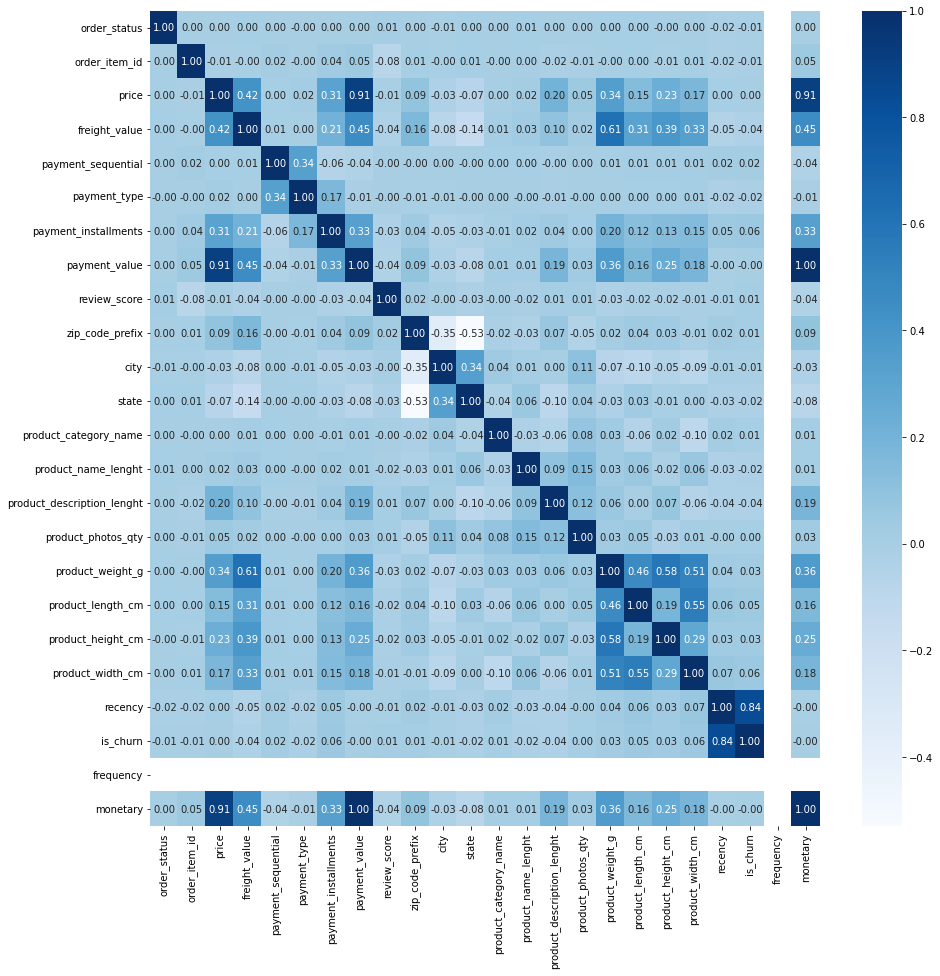

In [ ]:
plt.figure(figsize=(15, 15))
sns.heatmap(encoded_df.corr(), cmap='Blues', annot=True, fmt='.2f')
plt.show()

## Membagi Kolom Fitur dan Target

In [ ]:
X = encoded_df[['order_status',
                'price', 
                'freight_value',
                'payment_sequential', 
                'payment_type', 
                'payment_installments', 
                'payment_value', 
                'review_score', 
                'city', 
                'state', 
                'product_category_name',
                'recency', 
                'is_churn',
                'monetary']]

y = encoded_df['is_churn']

In [ ]:
from sklearn.feature_selection import mutual_info_classif

mutual_info = mutual_info_classif(X, y)
mutual_info

array([0.01115465, 0.06718099, 0.15672321, 0.01023019, 0.00950997,
       0.00296504, 0.14929218, 0.00627533, 0.0571088 , 0.0131172 ,
       0.02299992, 0.68821765, 0.69244984, 0.14873983])

In [ ]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info.sort_values(ascending=False)

is_churn                 0.692450
recency                  0.688218
freight_value            0.156723
payment_value            0.149292
monetary                 0.148740
price                    0.067181
city                     0.057109
product_category_name    0.023000
state                    0.013117
order_status             0.011155
payment_sequential       0.010230
payment_type             0.009510
review_score             0.006275
payment_installments     0.002965
dtype: float64

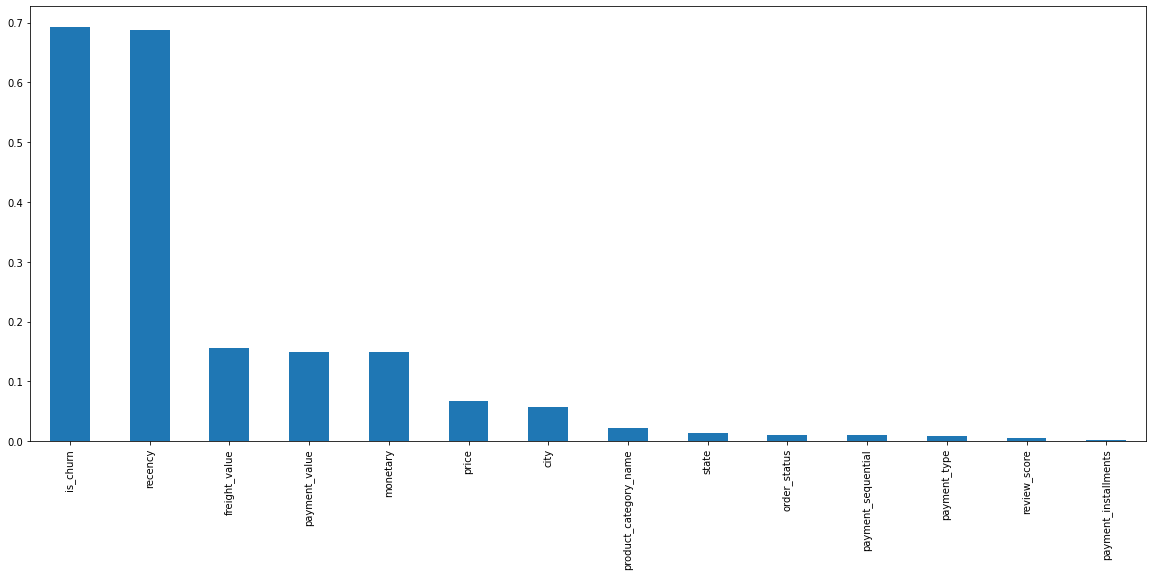

In [ ]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

## Membuat Baseline Model

In [ ]:
#Machine learning Model
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [ ]:
#Cross Validation -> Untuk menangani data yang tidak balance
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import RepeatedStratifiedKFold

In [ ]:
#Evaluation
from sklearn import metrics
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.metrics import make_scorer,accuracy_score,roc_auc_score,precision_score,recall_score,f1_score,log_loss
from sklearn.metrics import confusion_matrix

In [ ]:
# Modelling Algorithms
# StratifiedKFold adalah Cross Validation (CV)

kf = StratifiedKFold(n_splits=2,shuffle=True,random_state=42)

## Collect all model in one list
all_model = [DecisionTreeClassifier,
            LogisticRegression,
             KNeighborsClassifier,
             GaussianNB,
            SVC,
            LinearSVC,
            RandomForestClassifier,
            GradientBoostingClassifier,
            ExtraTreesClassifier,
             XGBClassifier]

model_name = ['DecisionTreeClassifier',
            'LogisticRegression',
             'KNeighborsClassifier',
             'GaussianNB',
            'SVC',
            'LinearSVC',
            'RandomForestClassifier',
            'GradientBoostingClassifier',
            'ExtraTreesClassifier',
             'XGBClassifier']
## loop for all model

datatr = []
datasc = []
Recall =[]
Precision =[]
auc =[]

for idx, model_type in enumerate(all_model):
    num = 1
    AccTrain = []
    AccTest = []
    RecallTemp = []
    PrecisionTemp = []
    AucTemp = []
    nfold = 1
    for train_index,test_index in kf.split(X,y): 

        print("----------BEFORE------------")
        print("{} Acc Train: {}, {} of KFold {}".format(model_name[idx], AccTrain, nfold, kf.n_splits))
        print("{} Acc Test: {}, {} of KFold {}".format(model_name[idx], AccTest, nfold, kf.n_splits))
        print("{} Recall: {}, {} of KFold {}".format(model_name[idx], RecallTemp, nfold, kf.n_splits))
        print("{} Precission: {}, {} of KFold {}".format(model_name[idx], PrecisionTemp, nfold, kf.n_splits))
        print("{} AUC: {}, {} of KFold {}".format(model_name[idx], AucTemp, nfold, kf.n_splits))
        print("---------------------------")
        
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        model = model_type()
        model.fit(X_train,y_train)
        y_pred=model.predict(X_test)
        
        AccTrain.append(model.score(X_train , y_train))
        AccTest.append(model.score(X_test , y_test))
        RecallTemp.append(recall_score(y_test,y_pred))
        PrecisionTemp.append(precision_score(y_test,y_pred))
        AucTemp.append(roc_auc_score(y_test, y_pred))
        
        print("----------AFTER------------")
        print("{} Acc Train: {}, {} of KFold {}".format(model_name[idx], AccTrain, nfold, kf.n_splits))
        print("{} Acc Test: {}, {} of KFold {}".format(model_name[idx], AccTest, nfold, kf.n_splits))
        print("{} Recall: {}, {} of KFold {}".format(model_name[idx], RecallTemp, nfold, kf.n_splits))
        print("{} Precission: {}, {} of KFold {}".format(model_name[idx], PrecisionTemp, nfold, kf.n_splits))
        print("{} AUC: {}, {} of KFold {}".format(model_name[idx], AucTemp, nfold, kf.n_splits))
        print("---------------------------")
        
        nfold += 1
    
    print("----------FINAL------------")
    print("{} Acc Train: {}".format(model_name[idx], np.mean(AccTrain)))
    print("{} Acc Test: {}".format(model_name[idx], np.mean(AccTest)))
    print("{} Recall: {}".format(model_name[idx], np.mean(RecallTemp)))
    print("{} Precission: {}".format(model_name[idx], np.mean(PrecisionTemp)))
    print("{} AUC: {}".format(model_name[idx], np.mean(AucTemp)))
    print("---------------------------")
    datatr.append(np.mean(AccTrain))
    datasc.append(np.mean(AccTest))
    Recall.append(np.mean(RecallTemp))
    Precision.append(np.mean(PrecisionTemp))
    auc.append(np.mean(AucTemp))

----------BEFORE------------
DecisionTreeClassifier Acc Train: [], 1 of KFold 2
DecisionTreeClassifier Acc Test: [], 1 of KFold 2
DecisionTreeClassifier Recall: [], 1 of KFold 2
DecisionTreeClassifier Precission: [], 1 of KFold 2
DecisionTreeClassifier AUC: [], 1 of KFold 2
---------------------------
----------AFTER------------
DecisionTreeClassifier Acc Train: [1.0], 1 of KFold 2
DecisionTreeClassifier Acc Test: [1.0], 1 of KFold 2
DecisionTreeClassifier Recall: [1.0], 1 of KFold 2
DecisionTreeClassifier Precission: [1.0], 1 of KFold 2
DecisionTreeClassifier AUC: [1.0], 1 of KFold 2
---------------------------
----------BEFORE------------
DecisionTreeClassifier Acc Train: [1.0], 2 of KFold 2
DecisionTreeClassifier Acc Test: [1.0], 2 of KFold 2
DecisionTreeClassifier Recall: [1.0], 2 of KFold 2
DecisionTreeClassifier Precission: [1.0], 2 of KFold 2
DecisionTreeClassifier AUC: [1.0], 2 of KFold 2
---------------------------
----------AFTER------------
DecisionTreeClassifier Acc Train: 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


----------AFTER------------
LogisticRegression Acc Train: [0.9361973628243301], 1 of KFold 2
LogisticRegression Acc Test: [0.9383679632504626], 1 of KFold 2
LogisticRegression Recall: [0.9493198564141319], 1 of KFold 2
LogisticRegression Precission: [0.9167578908958219], 1 of KFold 2
LogisticRegression AUC: [0.9393587560147181], 1 of KFold 2
---------------------------
----------BEFORE------------
LogisticRegression Acc Train: [0.9361973628243301], 2 of KFold 2
LogisticRegression Acc Test: [0.9383679632504626], 2 of KFold 2
LogisticRegression Recall: [0.9493198564141319], 2 of KFold 2
LogisticRegression Precission: [0.9167578908958219], 2 of KFold 2
LogisticRegression AUC: [0.9393587560147181], 2 of KFold 2
---------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


----------AFTER------------
LogisticRegression Acc Train: [0.9361973628243301, 0.9268411986133855], 2 of KFold 2
LogisticRegression Acc Test: [0.9383679632504626, 0.9262016163334751], 2 of KFold 2
LogisticRegression Recall: [0.9493198564141319, 0.9356194794766426], 2 of KFold 2
LogisticRegression Precission: [0.9167578908958219, 0.903855806525211], 2 of KFold 2
LogisticRegression AUC: [0.9393587560147181, 0.9270538110757037], 2 of KFold 2
---------------------------
----------FINAL------------
LogisticRegression Acc Train: 0.9315192807188578
LogisticRegression Acc Test: 0.9322847897919688
LogisticRegression Recall: 0.9424696679453872
LogisticRegression Precission: 0.9103068487105165
LogisticRegression AUC: 0.9332062835452108
---------------------------
----------BEFORE------------
KNeighborsClassifier Acc Train: [], 1 of KFold 2
KNeighborsClassifier Acc Test: [], 1 of KFold 2
KNeighborsClassifier Recall: [], 1 of KFold 2
KNeighborsClassifier Precission: [], 1 of KFold 2
KNeighborsClass

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


----------AFTER------------
LinearSVC Acc Train: [1.0], 1 of KFold 2
LinearSVC Acc Test: [0.9999574658131474], 1 of KFold 2
LinearSVC Recall: [0.9999055356130738], 1 of KFold 2
LinearSVC Precission: [1.0], 1 of KFold 2
LinearSVC AUC: [0.999952767806537], 1 of KFold 2
---------------------------
----------BEFORE------------
LinearSVC Acc Train: [1.0], 2 of KFold 2
LinearSVC Acc Test: [0.9999574658131474], 2 of KFold 2
LinearSVC Recall: [0.9999055356130738], 2 of KFold 2
LinearSVC Precission: [1.0], 2 of KFold 2
LinearSVC AUC: [0.999952767806537], 2 of KFold 2
---------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


----------AFTER------------
LinearSVC Acc Train: [1.0, 1.0], 2 of KFold 2
LinearSVC Acc Test: [0.9999574658131474, 1.0], 2 of KFold 2
LinearSVC Recall: [0.9999055356130738, 1.0], 2 of KFold 2
LinearSVC Precission: [1.0, 1.0], 2 of KFold 2
LinearSVC AUC: [0.999952767806537, 1.0], 2 of KFold 2
---------------------------
----------FINAL------------
LinearSVC Acc Train: 1.0
LinearSVC Acc Test: 0.9999787329065737
LinearSVC Recall: 0.999952767806537
LinearSVC Precission: 1.0
LinearSVC AUC: 0.9999763839032685
---------------------------
----------BEFORE------------
RandomForestClassifier Acc Train: [], 1 of KFold 2
RandomForestClassifier Acc Test: [], 1 of KFold 2
RandomForestClassifier Recall: [], 1 of KFold 2
RandomForestClassifier Precission: [], 1 of KFold 2
RandomForestClassifier AUC: [], 1 of KFold 2
---------------------------
----------AFTER------------
RandomForestClassifier Acc Train: [1.0], 1 of KFold 2
RandomForestClassifier Acc Test: [1.0], 1 of KFold 2
RandomForestClassifier Re

In [ ]:
## compare model each other
data_hasil = pd.DataFrame()
data_hasil['model'] = model_name
data_hasil['Accuracy training'] = datatr
data_hasil['Accuracy test'] = datasc
data_hasil['Precision'] = Precision
data_hasil['Recall']= Recall
data_hasil['AUC']=auc
data_hasil['gap'] = abs(data_hasil['Accuracy training'] - data_hasil['Accuracy test'])
data_hasil.sort_values(by='Accuracy test',ascending=False)

,model,Accuracy training,Accuracy test,Precision,Recall,AUC,gap
0,DecisionTreeClassifier,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
3,GaussianNB,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
6,RandomForestClassifier,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
7,GradientBoostingClassifier,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,ExtraTreesClassifier,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
9,XGBClassifier,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
5,LinearSVC,1.000000,0.999979,1.000000,0.999953,0.999976,0.000021
4,SVC,0.996565,0.996097,0.999548,0.991781,0.995707,0.000468
2,KNeighborsClassifier,0.994875,0.991153,0.992409,0.987908,0.990859,0.003722
1,LogisticRegression,0.931519,0.932285,0.910307,0.942470,0.933206,0.000766


## Mengaplikasikan Hyperparameter Tuning

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Grid Search
from sklearn.model_selection import GridSearchCV

In [ ]:
#Grid Search

model = LogisticRegression()

param = dict()
param['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
param['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
param['C'] = [0.00001, 0.0001, 0.001,0.003,0.005,0.01,0.03,0.05,0.1,0.3,0.5,1,2,3,3,4,5,10,20, 100]

cv = StratifiedKFold(n_splits=2)
clf1 = GridSearchCV(model,param,  scoring='accuracy', n_jobs=-1, cv=cv, verbose = 4)
clf1.fit(X,y)

Fitting 2 folds for each of 240 candidates, totalling 480 fits


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.003, 0.005, 0.01, 0.03,
                               0.05, 0.1, 0.3, 0.5, 1, 2, 3, 3, 4, 5, 10, 20,
                               100],
                         'penalty': ['none', 'l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='accuracy', verbose=4)

In [ ]:
print('Best Score: {}'.format(clf1.best_score_))
print('Best Hyperparameters: {}'.format(clf1.best_params_))

Best Score: 1.0
Best Hyperparameters: {'C': 1e-05, 'penalty': 'none', 'solver': 'newton-cg'}


In [ ]:
#Train-Test Split
from sklearn.model_selection import train_test_split

In [ ]:
# Membagi data training dan data testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

print("X_train dataset shape: ", X_train.shape)
print("y_train dataset shape: ", y_train.shape)
print("X_test dataset shape: ", X_test.shape)
print("y_test dataset shape: ", y_test.shape)

X_train dataset shape:  (79934, 14)
y_train dataset shape:  (79934,)
X_test dataset shape:  (14107, 14)
y_test dataset shape:  (14107,)


In [ ]:
# Buat Model Pakai Best Param Dari GridSearchCV
modeltun = LogisticRegression(**clf1.best_params_)

In [ ]:
# Melatih Model Pakai data train kita
model_fit = modeltun.fit(X_train,y_train)

In [ ]:
# Cek Peforma model data latih
y_pred_train=model_fit.predict(X_train)
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     43891
        True       1.00      1.00      1.00     36043

    accuracy                           1.00     79934
   macro avg       1.00      1.00      1.00     79934
weighted avg       1.00      1.00      1.00     79934



In [ ]:
# Cek Peforma model data test
y_pred_test=model_fit.predict(X_test)
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      7807
        True       1.00      1.00      1.00      6300

    accuracy                           1.00     14107
   macro avg       1.00      1.00      1.00     14107
weighted avg       1.00      1.00      1.00     14107



In [ ]:
# session_counts = df['customer_id'].value_counts(ascending=False)
# multi_users = session_counts[session_counts > 1].count()

# print(f'Terdapat {multi_users} nasabah yang muncul lebih dari sekali didalam dataset')